## Imports and Data

In [1]:
import re, pandas as pd, matplotlib.pyplot as plt, numpy as np
from sklearn.feature_extraction.text import CountVectorizer # LDA uses term frequencies
from sklearn.decomposition import LatentDirichletAllocation # LDA we are going to use

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [45]:
%matplotlib inline

In [49]:
plt.figure( figsize=(20,10) )

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [14]:
df = pd.read_csv('../output/TEDall_speakers.csv', index_col=0)
print(df.shape)
df.head()

(1747, 26)


,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,...,speaker2_introduction,speaker2_profile,speaker_3,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile
Set,,,,,,,,,,,,,,,,,,,,,
only,1,https://www.ted.com/talks/al_gore_on_averting_...,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,0:16:17,6/27/06,"alternative energy,cars,global issues,climate ...",3266733,"Thank you so much, Chris. And it's truly a g...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
only,7,https://www.ted.com/talks/david_pogue_says_sim...,Simplicity sells,New York Times columnist David Pogue takes aim...,TED2006,0:21:26,6/27/06,"simplicity,entertainment,interface design,soft...",1702201,"(Music: ""The Sound of Silence,"" Simon & Garf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
only,53,https://www.ted.com/talks/majora_carter_s_tale...,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",TED2006,0:18:36,6/27/06,"MacArthur grant,cities,green,activism,politics...",2000421,If you're here today — and I'm very happy th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
only,66,https://www.ted.com/talks/ken_robinson_says_sc...,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,TED2006,0:19:24,6/27/06,"children,teaching,creativity,parenting,culture...",51614087,Good morning. How are you? (Laughter) ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
only,92,https://www.ted.com/talks/hans_rosling_shows_t...,The best stats you've ever seen,You've never seen data presented like this. Wi...,TED2006,0:19:50,6/27/06,"demo,Asia,global issues,visualizations,global ...",12662135,"About 10 years ago, I took on the task to te...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Create list of just the texts of the talks
texts = df.text.tolist()

In [40]:
from wordcloud import WordCloud

In [41]:
# Join the texts together.
long_string = ','.join(texts)

In [51]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3,
                      width=1800, 
                      height=900,
                      contour_color='steelblue')

In [53]:
# Generate a word cloud
wordcloud.generate(long_string)

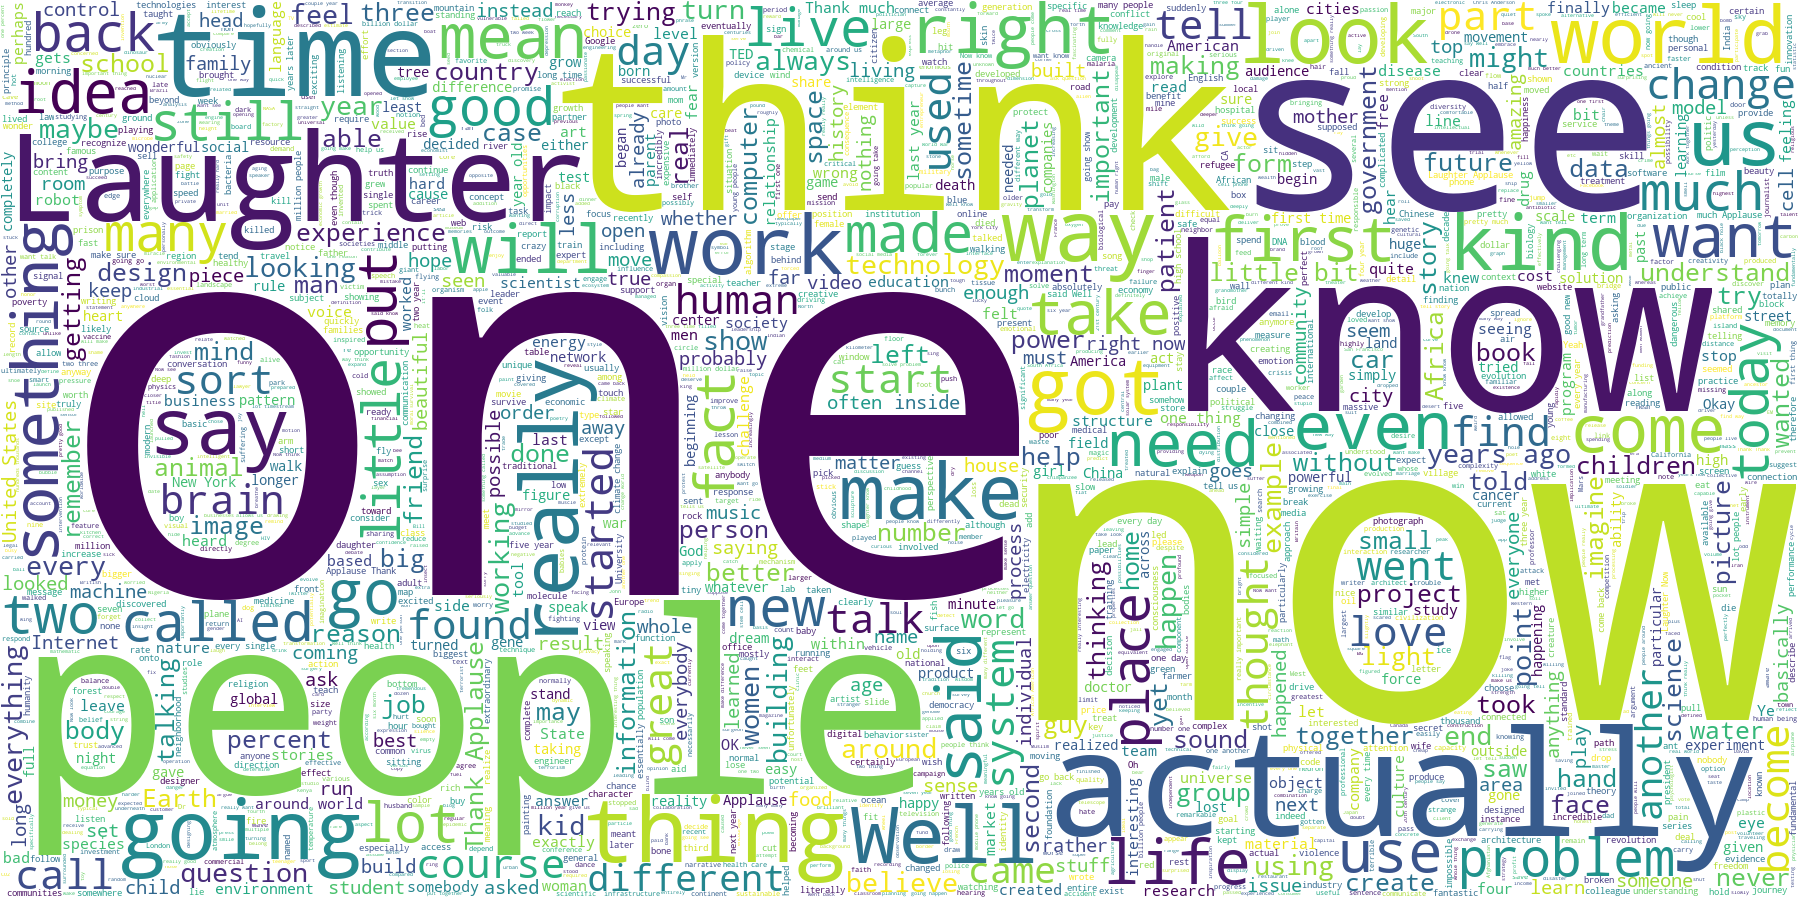

In [54]:
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
# Alternate way to show image
# plt.imshow(wordcloud)

In [57]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

## Topic Modeling

RG thread on [What is a good way to perform topic modeling on short text?](https://www.researchgate.net/post/What_is_a_good_way_to_perform_topic_modeling_on_short_text)

### Notes on Parameters

* **Alpha** parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
* **Beta** parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

[Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

In [17]:
# Create vectorizer: pass parameters here
vectorizer = CountVectorizer()

In [19]:
tf_all = vectorizer.fit_transform(texts)
tf_all.shape

(1747, 50379)

We are not taking much off the top end with the code below: a term has to occur in 100% of documents to be ignored. At the bottom end, we are simply taking away terms that occur across fewer than three documents. (If we increase it to 5, we love an additional 6000 words.)

In [33]:
vec_fewer = CountVectorizer(max_df = 1.0,
                            min_df = 3,
                            stop_words='english',             # remove stop words
                            lowercase=True,                   # convert all words to lowercase
                            token_pattern='[a-zA-Z0-9]{3,}')  # num chars > 3

In [34]:
tf_fewer = vec_fewer.fit_transform(texts)
tf_fewer.shape

(1747, 22137)

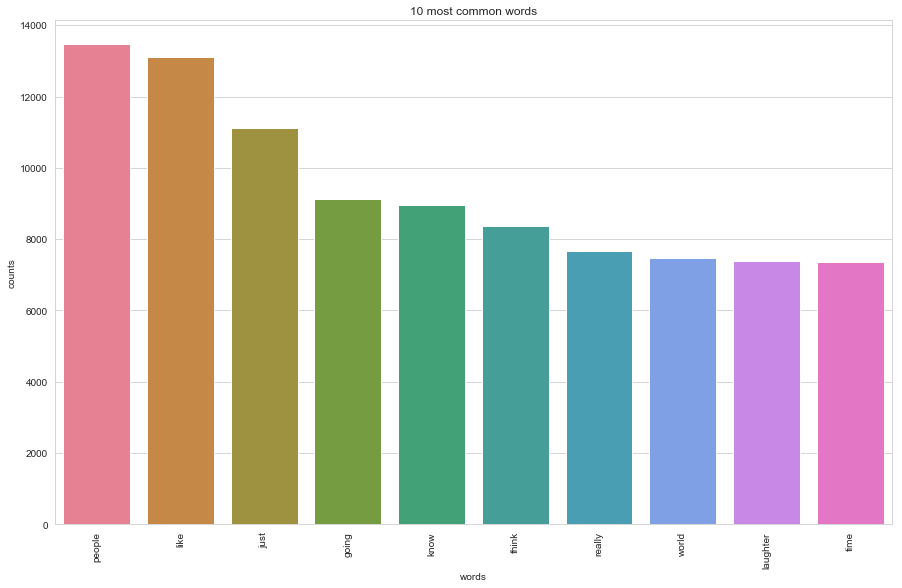

In [60]:
# Visualise the 10 most common words
plot_10_most_common_words(tf_fewer, vec_fewer)

In [36]:
# Check the sparsity of the matrix:

# Materialize the sparse data
dense = tf_fewer.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsity: ", ((dense > 0).sum()/dense.size)*100, "%")

Sparsity:  1.9835809884427098 %


In [66]:
# LDA needs to be told how many topics to expect:
n_topics = 100
n_words = 10

In [38]:
# First we configure our LDA-izer:
lda = LatentDirichletAllocation(n_components = n_topics, 
                                max_iter = 20, 
                                learning_method = 'online', 
                                learning_offset = 50.,
                                random_state = 0)

In [39]:
lda.fit(tf_fewer)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=100, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [32]:
display_topics(lda, tf_feature_names, n_top_words)
# Get W (DTM) and H (WTM) arrays
lda_W = lda.transform(tf)
lda_H = lda.components_

df_lda_DTM = pd.DataFrame(data= lda_W, index = docs, columns = topic_labels)
# df_lda_DTM.to_csv('../outputs/lda_DTM.csv', sep=',')
print(df_lda_DTM)

NameError: name 'display_topics' is not defined

In [69]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx}, ")
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [70]:
print("Topics found via LDA:")
print_topics(lda, vec_fewer, n_words)

Topics found via LDA:

Topic 0, 
laughter just world like don going really want people got

Topic 1, 
technology life things actually way just think time evolution don

Topic 2, 
people world like life know make way right years community

Topic 3, 
images janitor flickr marries haired noah semantic dame notre dickens

Topic 4, 
people like life time way just ideas world thing laughter

Topic 5, 
integrates narcissism stop odds consequently diodes educational earns advisor patron

Topic 6, 
like don going people world laughter really think just know

Topic 7, 
just brain think actually going foot love like really shrimp

Topic 8, 
said world don people think laughter really know like culture

Topic 9, 
people laughter know say don like think world just years

Topic 10, 
hip epiphany vest allison youngest canadian casually volunteering cheats draped

Topic 11, 
people just think like know going say said way really

Topic 12, 
coffee howard sauce tomato clusters spaghetti authentic soup e

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?
